In [ ]:
import pandas as pd

df = pd.read_csv("delhivery_data_feature_Engineering.csv")

#Understading data of file and finding missing value is there or not
print(df.head())
print(df.info())
print(df.describe())
print(df.shape )
print(df.isnull().sum())



       data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                 source_name  \
0  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
3  trip-153741093647649320  IND388121AAA  Anand_VU

In [ ]:
# Fill missing values for source_name and destination_name with a placeholder
df['source_name'].fillna('Unknown-Unknown', inplace=True)
df['destination_name'].fillna('Unknown-Unknown', inplace=True)


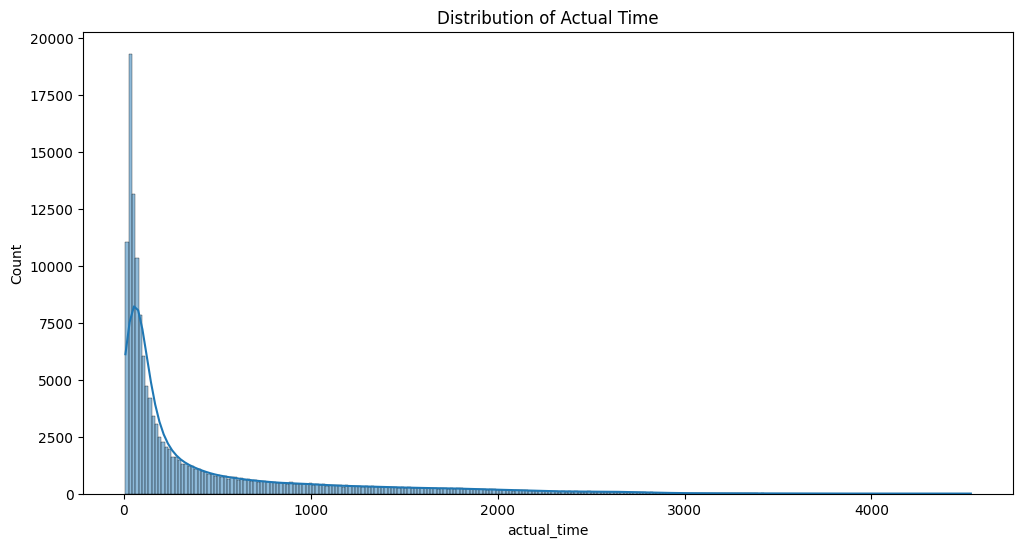

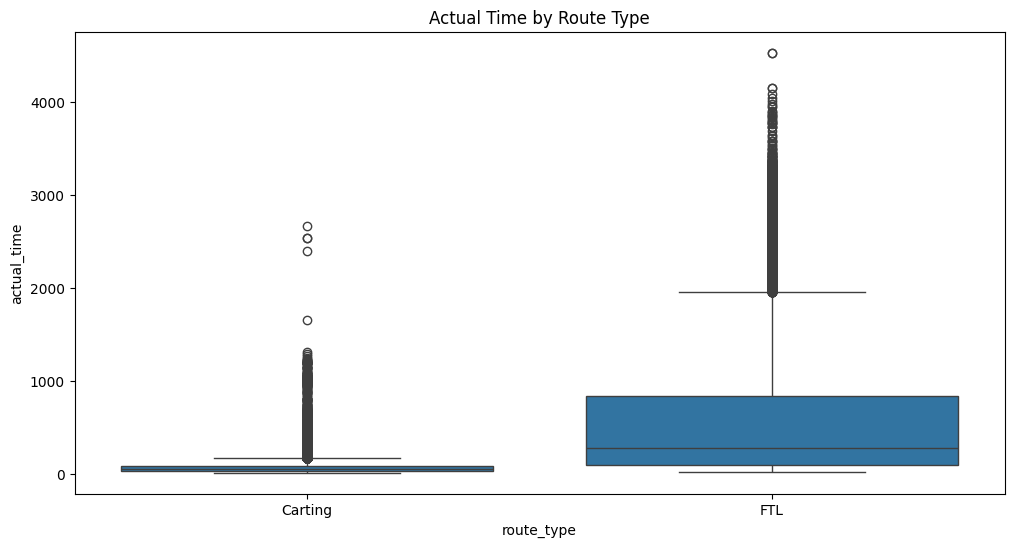

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plots for continuous variables
plt.figure(figsize=(12, 6))
sns.histplot(df['actual_time'], kde=True)
plt.title('Distribution of Actual Time')
plt.show()

# Box plots for categorical variables
plt.figure(figsize=(12, 6))
sns.boxplot(x='route_type', y='actual_time', data=df)
plt.title('Actual Time by Route Type')
plt.show()


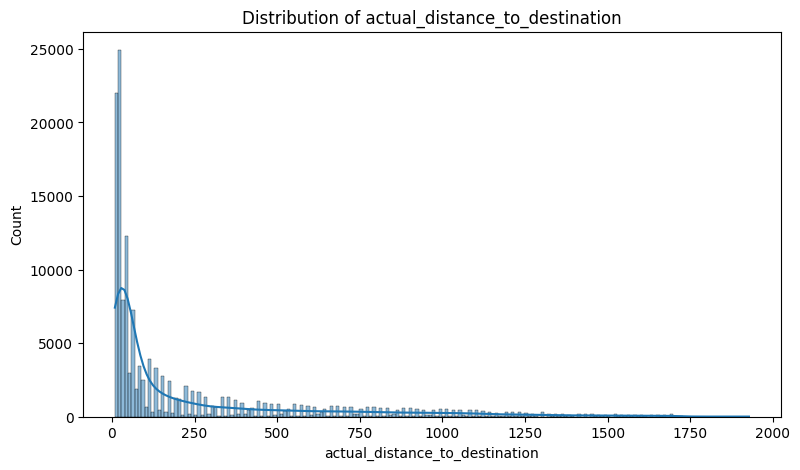

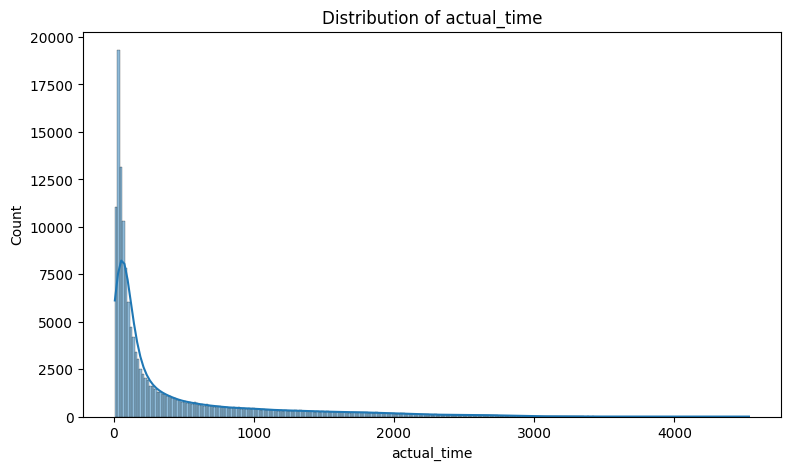

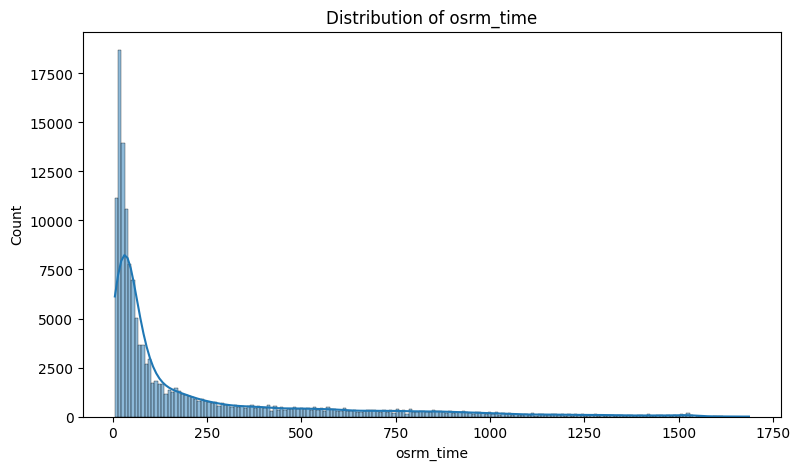

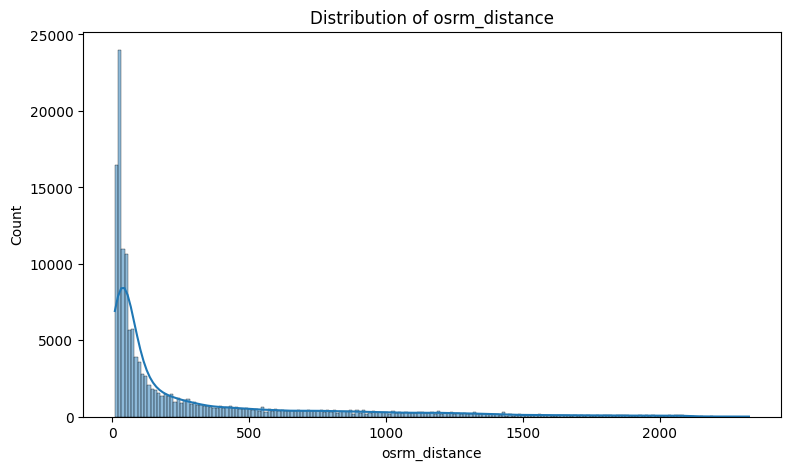

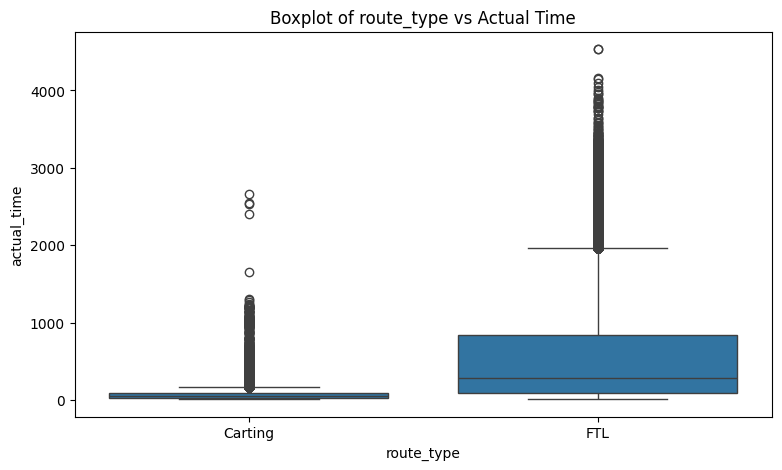

In [ ]:
# Distribution plots
continuous_vars = ['actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance']
for var in continuous_vars:
    plt.figure(figsize=(9, 5))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

# Boxplots for categorical variables
categorical_vars = ['route_type']
for var in categorical_vars:
    plt.figure(figsize=(9, 5))
    sns.boxplot(x=df[var], y=df['actual_time'])
    plt.title(f'Boxplot of {var} vs Actual Time')
    plt.show()

In [ ]:
# Extracting city and state from source_name and destination_name
df[['source_name_clean', 'source_state']] = df['source_name'].str.extract(r'^(.*)_.*\((.*)\)$')
df[['destination_name_clean', 'destination_state']] = df['destination_name'].str.extract(r'^(.*)_.*\((.*)\)$')

# Extracting date features from trip_creation_time
df['trip_creation_time'] = pd.to_datetime(df['trip_creation_time'])
df['creation_year'] = df['trip_creation_time'].dt.year
df['creation_month'] = df['trip_creation_time'].dt.month
df['creation_day'] = df['trip_creation_time'].dt.day


In [ ]:
# Aggregation on trip_uuid, source_center, and destination_center
agg_funcs = {
    'start_scan_to_end_scan': 'sum',
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
}

df_aggregated = df.groupby(['trip_uuid', 'source_center', 'destination_center']).agg(agg_funcs).reset_index()

# Further aggregation on just trip_uuid
df_final_agg = df_aggregated.groupby('trip_uuid').agg(agg_funcs).reset_index()


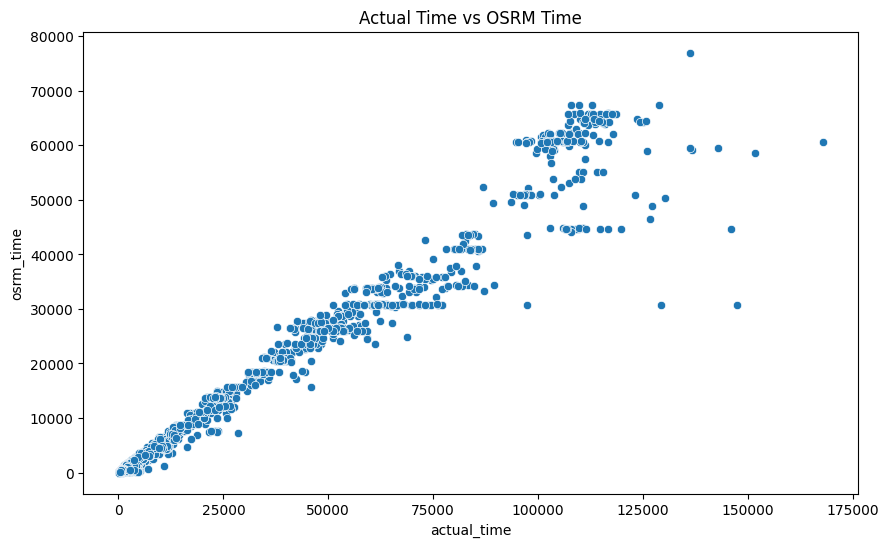

T-test: t_stat=14.073444960610715, p_value=7.714905383019579e-45


In [ ]:
# Visual Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final_agg, x='actual_time', y='osrm_time')
plt.title('Actual Time vs OSRM Time')
plt.show()

# Hypothesis Testing
from scipy.stats import ttest_ind

actual_time = df_final_agg['actual_time']
osrm_time = df_final_agg['osrm_time']

t_stat, p_value = ttest_ind(actual_time, osrm_time)
print(f'T-test: t_stat={t_stat}, p_value={p_value}')


In [ ]:
# Outlier treatment using IQR
# Select only numerical columns
numerical_cols = df_final_agg.select_dtypes(include=['number']).columns
Q1 = df_final_agg[numerical_cols].quantile(0.25)
Q3 = df_final_agg[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Apply outlier removal to numerical columns only
df_final_agg = df_final_agg[~((df_final_agg[numerical_cols] < (Q1 - 1.5 * IQR)) | (df_final_agg[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

**Business Insights:**

Order Sources:

Most orders are originating from certain states or corridors, highlighting key regions for business.

Busiest Corridors:

Identifying the busiest corridors by average distance and time taken.

**Recommendations:**

Optimize Routes:

Focus on optimizing routes in the busiest corridors to reduce delivery times.

Resource Allocation:

Allocate more resources to states with higher order volumes to improve efficiency.

Predictive Maintenance:

Use the time and distance data to predict and schedule maintenance for vehicles to prevent delays.